# Why not using L2 regularization is better than L2 regularization?

#### Case of MNIST

### Background

We are having a study group for Stockholm AI soon. During a discussion with my friend, Carl, I told him that it is common to use L2 regularization and L1 at the same time. We then continued the dicussion and I started to wonder: would it actually perform the performance of a simple MLP on a simple data like MNIST? But then I started a simple experiment: let's compare the performance of an MLP with no regularization with L1, L2 and a combination of L1 and L2 regularization.

### Experiment

Before anything else, let's ensure reproducibility:

In [35]:
import numpy
import tensorflow

numpy.random.seed(7)
tensorflow.set_random_seed(2)

I usually like to import everything first: 

In [37]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import regularizers
from keras import optimizers
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

### F1 score

In order to have a broader perspective on the measures, I decided to add F1 score to the model as well:

In [41]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall %f" % (_val_f1, _val_precision, _val_recall))
        
        return
 
metrics = Metrics()

Let's prepare the dataset:

In [39]:
batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


### A simple MLP with no regularization

Here is the simplest MLP one can find. The point with this MLP is not that it should be the state-of-the-art among MLPs, since the model is not going to change:

In [31]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
# model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test), callbacks=[metrics])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.2210 - acc: 0.9315 - val_loss: 0.1121 - val_acc: 0.9663
 — val_f1: 0.966631 — val_precision: 0.973047 — val_recall 0.960300
Epoch 2/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.0810 - acc: 0.9750 - val_loss: 0.0876 - val_acc: 0.9740
 — val_f1: 0.974578 — val_precision: 0.977371 — val_recall 0.971800
Epoch 3/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.0529 - acc: 0.9839 - val_loss: 0.0848 - val_acc: 0.9766
 — val_f1: 0.976665 — val_precision: 0.978134 — val_recall 0.975200
Epoch 4/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.0393 - acc: 0.9882 - val_loss: 0.0748 - val_acc: 0.9796
 — val_f1: 0.980125 — val_precision: 0.981353 — val_recall 0.978900
Epoch 5/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.0290 - acc: 0.9911 - val_loss: 0.0914 - val_acc: 

### L2 regularization

So we all know that L2 regularization helps generalizatin of a neural network or any ML model, right? I thought so too. So I started checking the usual parameter for L2 regulariztion, namely 0.001:

In [32]:
model_2 = Sequential()
model_2.add(Dense(512, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(0.001)))
# model_2.add(Dropout(0.2))
model_2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model_2.add(Dropout(0.2))
model_2.add(Dense(num_classes, activation='softmax'))

# model_2.summary()

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test), callbacks=[metrics])
score_2 = model_2.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.6435 - acc: 0.9214 - val_loss: 0.3163 - val_acc: 0.9584
 — val_f1: 0.959798 — val_precision: 0.967107 — val_recall 0.952600
Epoch 2/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2673 - acc: 0.9605 - val_loss: 0.2338 - val_acc: 0.9621
 — val_f1: 0.962425 — val_precision: 0.970897 — val_recall 0.954100
Epoch 3/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2058 - acc: 0.9674 - val_loss: 0.1847 - val_acc: 0.9729
 — val_f1: 0.973364 — val_precision: 0.978379 — val_recall 0.968400
Epoch 4/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.1811 - acc: 0.9704 - val_loss: 0.1912 - val_acc: 0.9673
 — val_f1: 0.966720 — val_precision: 0.971998 — val_recall 0.961500
Epoch 5/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.1631 - acc: 0.9736 - val_loss: 0.1777 - val_acc: 

I was confused a bit. How can the network with L2 regularization perform worse than the one without it? Isn't one the promise of regularization is to help generalization? Could it be that the L2 coefficient needs more tuning?

### Hyperparamter optimization of L2 regularization

In [8]:
def objective(params):
    model_2 = Sequential()
    model_2.add(Dense(512, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(params['l2'])))
    # model_2.add(Dropout(0.2))
    model_2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(params['l2'])))
    # model_2.add(Dropout(0.2))
    model_2.add(Dense(num_classes, activation='softmax'))

    model_2.summary()
    
    print('training with L2 regularization parameter', params['l2'])
    
    model_2.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score_2 = model_2.evaluate(x_test, y_test, verbose=0)
    
    print('Test loss:', score_2[0])
    print('Test accuracy:', score_2[1])

    return {'loss': - score_2[1], 'status': STATUS_OK} 

space = {
    'l2': hp.uniform('l2', 0.0001, 5)
}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals = 30)
print (best)
print (trials.best_trial)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.8196639854552179
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 17us/step - loss: 31.1118 - acc: 0.1522 - val_loss: 2.4363 - val_acc: 0.1135
Epoch 2/20
60000/60000 [==============================] - 1s 15us/step - loss: 2.4380 - acc: 0.1115 - val_loss: 2.4372 - val_acc: 0.1135
Epoch 3/20
600

60000/60000 [==============================] - 1s 14us/step - loss: 2.6728 - acc: 0.1124 - val_loss: 2.6725 - val_acc: 0.1135
Epoch 8/20
60000/60000 [==============================] - 1s 14us/step - loss: 2.6728 - acc: 0.1124 - val_loss: 2.6725 - val_acc: 0.1135
Epoch 9/20
60000/60000 [==============================] - 1s 14us/step - loss: 2.6728 - acc: 0.1124 - val_loss: 2.6724 - val_acc: 0.1135
Epoch 10/20
60000/60000 [==============================] - 1s 14us/step - loss: 2.6728 - acc: 0.1124 - val_loss: 2.6725 - val_acc: 0.1135
Epoch 11/20
60000/60000 [==============================] - 1s 14us/step - loss: 2.6727 - acc: 0.1124 - val_loss: 2.6726 - val_acc: 0.1135
Epoch 12/20
60000/60000 [==============================] - 1s 14us/step - loss: 2.6728 - acc: 0.1124 - val_loss: 2.6725 - val_acc: 0.1135
Epoch 13/20
60000/60000 [==============================] - 1s 14us/step - loss: 2.6728 - acc: 0.1124 - val_loss: 2.6725 - val_acc: 0.1135
Epoch 14/20
60000/60000 [=======================

60000/60000 [==============================] - 1s 15us/step - loss: 2.7195 - acc: 0.1124 - val_loss: 2.7194 - val_acc: 0.1135
Epoch 20/20
60000/60000 [==============================] - 1s 16us/step - loss: 2.7195 - acc: 0.1124 - val_loss: 2.7193 - val_acc: 0.1135
Test loss: 2.719317379760742
Test accuracy: 0.1135
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_36 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.8278994807864386
Train on 60000 samples, 

60000/60000 [==============================] - 1s 21us/step - loss: 108.2448 - acc: 0.1365 - val_loss: 2.8009 - val_acc: 0.1135
Epoch 2/20
60000/60000 [==============================] - 1s 16us/step - loss: 2.8012 - acc: 0.1107 - val_loss: 2.8017 - val_acc: 0.1135
Epoch 3/20
60000/60000 [==============================] - 1s 16us/step - loss: 2.8011 - acc: 0.1119 - val_loss: 2.8011 - val_acc: 0.1135
Epoch 4/20
60000/60000 [==============================] - 1s 16us/step - loss: 2.8011 - acc: 0.1124 - val_loss: 2.8005 - val_acc: 0.1135
Epoch 5/20
60000/60000 [==============================] - 1s 16us/step - loss: 2.8009 - acc: 0.1123 - val_loss: 2.8008 - val_acc: 0.1135
Epoch 6/20
60000/60000 [==============================] - 1s 15us/step - loss: 2.8009 - acc: 0.1124 - val_loss: 2.8008 - val_acc: 0.1135
Epoch 7/20
60000/60000 [==============================] - 1s 16us/step - loss: 2.8009 - acc: 0.1124 - val_loss: 2.8005 - val_acc: 0.1135
Epoch 8/20
60000/60000 [==========================

60000/60000 [==============================] - 1s 15us/step - loss: 3.1271 - acc: 0.1124 - val_loss: 3.1269 - val_acc: 0.1135
Epoch 14/20
60000/60000 [==============================] - 1s 15us/step - loss: 3.1271 - acc: 0.1124 - val_loss: 3.1268 - val_acc: 0.1135
Epoch 15/20
60000/60000 [==============================] - 1s 15us/step - loss: 3.1270 - acc: 0.1124 - val_loss: 3.1268 - val_acc: 0.1135
Epoch 16/20
60000/60000 [==============================] - 1s 15us/step - loss: 3.1270 - acc: 0.1124 - val_loss: 3.1269 - val_acc: 0.1135
Epoch 17/20
60000/60000 [==============================] - 1s 15us/step - loss: 3.1270 - acc: 0.1124 - val_loss: 3.1267 - val_acc: 0.1135
Epoch 18/20
60000/60000 [==============================] - 1s 15us/step - loss: 3.1271 - acc: 0.1124 - val_loss: 3.1268 - val_acc: 0.1135
Epoch 19/20
60000/60000 [==============================] - 1s 15us/step - loss: 3.1270 - acc: 0.1124 - val_loss: 3.1268 - val_acc: 0.1135
Epoch 20/20
60000/60000 [=====================

60000/60000 [==============================] - 1s 22us/step - loss: 3.9693 - acc: 0.7766 - val_loss: 1.1037 - val_acc: 0.7551
Epoch 2/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.9106 - acc: 0.8509 - val_loss: 0.7897 - val_acc: 0.8831
Epoch 3/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.7905 - acc: 0.8690 - val_loss: 0.7194 - val_acc: 0.8869
Epoch 4/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.7318 - acc: 0.8763 - val_loss: 0.6674 - val_acc: 0.8930
Epoch 5/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.6902 - acc: 0.8843 - val_loss: 0.6529 - val_acc: 0.9013
Epoch 6/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.6630 - acc: 0.8886 - val_loss: 0.6714 - val_acc: 0.8766
Epoch 7/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.6395 - acc: 0.8918 - val_loss: 0.5981 - val_acc: 0.9034
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 15us/step - loss: 0.3373 - acc: 0.9465 - val_loss: 0.3234 - val_acc: 0.9477
Epoch 14/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3310 - acc: 0.9472 - val_loss: 0.3368 - val_acc: 0.9398
Epoch 15/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3294 - acc: 0.9466 - val_loss: 0.3163 - val_acc: 0.9539
Epoch 16/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3244 - acc: 0.9469 - val_loss: 0.3012 - val_acc: 0.9538
Epoch 17/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3191 - acc: 0.9483 - val_loss: 0.2971 - val_acc: 0.9565
Epoch 18/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3155 - acc: 0.9486 - val_loss: 0.2983 - val_acc: 0.9523
Epoch 19/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.3131 - acc: 0.9492 - val_loss: 0.3187 - val_acc: 0.9466
Epoch 20/20
60000/60000 [=====================

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 27us/step - loss: 43.1862 - acc: 0.1497 - val_loss: 2.4947 - val_acc: 0.1135
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4947 - acc: 0.1110 - val_loss: 2.4954 - val_acc: 0.1009
Epoch 3/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4946 - acc: 0.1112 - val_loss: 2.4943 - val_acc: 0.1135
Epoch 4/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4944 - acc: 0.1121 - val_loss: 2.4941 - val_acc: 0.1135
Epoch 5/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4943 - acc: 0.1124 - val_loss: 2.4941 - val_acc: 0.1135
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4943 - acc: 0.1124 - val_loss: 2.4941 - val_acc: 0.1135
Epoch 7/20
60000/60000 [==============================] - 1s 17us/step - loss: 2.4942 - acc: 0.1124 - val_loss: 2.4940 - val_ac

### Visualizing the result

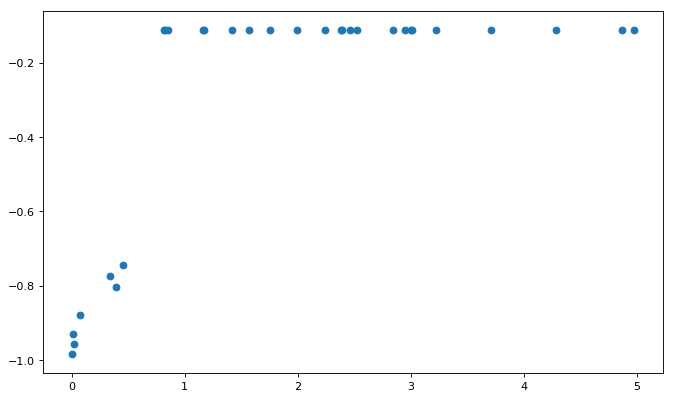

In [10]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

t = trials.trials

y = []
x = []
for tr in t: 
    y.append((tr['result']['loss']))
    x.append(tr['misc']['vals']['l2'])
    

plt.scatter(x, y)
plt.plot()
plt.show()

Just to be sure, let's run another trial with values between 0 and 1 only: 

In [42]:
def objective(params):
    model_2 = Sequential()
    model_2.add(Dense(512, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(params['l2'])))
    # model_2.add(Dropout(0.2))
    model_2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(params['l2'])))
    # model_2.add(Dropout(0.2))
    model_2.add(Dense(num_classes, activation='softmax'))

    model_2.summary()
    
    print('training with L2 regularization parameter', params['l2'])
    
    model_2.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score_2 = model_2.evaluate(x_test, y_test, verbose=0)
    
    print('Test loss:', score_2[0])
    print('Test accuracy:', score_2[1])

    return {'loss': - score_2[1], 'status': STATUS_OK} 

space = {
    'l2': hp.uniform('l2', 0.00001, 1)
}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals = 50)
print (best)
print (trials.best_trial)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_233 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_234 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.04295182815892902
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 41us/step - loss: 2.7877 - acc: 0.8176 - val_loss: 0.8089 - val_acc: 0.8785
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.7735 - acc: 0.8726 - val_loss: 0.6624 - val_acc: 0.8965
Epoch 3/20
600

60000/60000 [==============================] - 2s 39us/step - loss: 7.3102 - acc: 0.6952 - val_loss: 1.3083 - val_acc: 0.7563
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.1589 - acc: 0.8091 - val_loss: 1.0566 - val_acc: 0.8283
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.0198 - acc: 0.8308 - val_loss: 0.9513 - val_acc: 0.8539
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.9473 - acc: 0.8375 - val_loss: 0.9095 - val_acc: 0.8399
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8989 - acc: 0.8460 - val_loss: 0.8419 - val_acc: 0.8618
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8666 - acc: 0.8479 - val_loss: 0.8971 - val_acc: 0.8163
Epoch 7/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8434 - acc: 0.8489 - val_loss: 0.8818 - val_acc: 0.8193
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 18us/step - loss: 0.9057 - acc: 0.8416 - val_loss: 0.8664 - val_acc: 0.8494
Epoch 8/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8855 - acc: 0.8418 - val_loss: 0.8950 - val_acc: 0.8287
Epoch 9/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8683 - acc: 0.8433 - val_loss: 0.8502 - val_acc: 0.8511
Epoch 10/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8547 - acc: 0.8440 - val_loss: 0.9425 - val_acc: 0.7835
Epoch 11/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8431 - acc: 0.8450 - val_loss: 0.8017 - val_acc: 0.8592
Epoch 12/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8307 - acc: 0.8449 - val_loss: 0.8089 - val_acc: 0.8489
Epoch 13/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8240 - acc: 0.8447 - val_loss: 0.8422 - val_acc: 0.8311
Epoch 14/20
60000/60000 [=======================

60000/60000 [==============================] - 1s 18us/step - loss: 2.4017 - acc: 0.1124 - val_loss: 2.4016 - val_acc: 0.1135
Epoch 14/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4018 - acc: 0.1124 - val_loss: 2.4015 - val_acc: 0.1135
Epoch 15/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4018 - acc: 0.1124 - val_loss: 2.4015 - val_acc: 0.1135
Epoch 16/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4018 - acc: 0.1124 - val_loss: 2.4015 - val_acc: 0.1135
Epoch 17/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4018 - acc: 0.1124 - val_loss: 2.4015 - val_acc: 0.1135
Epoch 18/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4017 - acc: 0.1124 - val_loss: 2.4015 - val_acc: 0.1135
Epoch 19/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4017 - acc: 0.1124 - val_loss: 2.4015 - val_acc: 0.1135
Epoch 20/20
60000/60000 [=====================

60000/60000 [==============================] - 1s 18us/step - loss: 1.2237 - acc: 0.7238 - val_loss: 1.1897 - val_acc: 0.7399
Epoch 20/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.2163 - acc: 0.7255 - val_loss: 1.2006 - val_acc: 0.7295
Test loss: 1.20057587890625
Test accuracy: 0.7295
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_259 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_260 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_261 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.950098770062801
Train on 60000 samples, va

60000/60000 [==============================] - 3s 42us/step - loss: 6.0323 - acc: 0.7285 - val_loss: 1.1261 - val_acc: 0.8412
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.0731 - acc: 0.8323 - val_loss: 0.9448 - val_acc: 0.8541
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.9334 - acc: 0.8500 - val_loss: 0.8543 - val_acc: 0.8687
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8679 - acc: 0.8580 - val_loss: 0.8951 - val_acc: 0.8301
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.8291 - acc: 0.8612 - val_loss: 0.7900 - val_acc: 0.8675
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7937 - acc: 0.8674 - val_loss: 0.7420 - val_acc: 0.8864
Epoch 7/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7705 - acc: 0.8701 - val_loss: 0.7627 - val_acc: 0.8652
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 18us/step - loss: 0.7778 - acc: 0.8683 - val_loss: 0.7566 - val_acc: 0.8714
Epoch 8/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7595 - acc: 0.8690 - val_loss: 0.7242 - val_acc: 0.8767
Epoch 9/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.7438 - acc: 0.8701 - val_loss: 0.7755 - val_acc: 0.8399
Epoch 10/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7297 - acc: 0.8704 - val_loss: 0.6901 - val_acc: 0.8891
Epoch 11/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7225 - acc: 0.8709 - val_loss: 0.7195 - val_acc: 0.8647
Epoch 12/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7124 - acc: 0.8730 - val_loss: 0.6685 - val_acc: 0.8889
Epoch 13/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7024 - acc: 0.8736 - val_loss: 0.7690 - val_acc: 0.8467
Epoch 14/20
60000/60000 [=======================

60000/60000 [==============================] - 1s 18us/step - loss: 2.4299 - acc: 0.1124 - val_loss: 2.4298 - val_acc: 0.1135
Epoch 14/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4299 - acc: 0.1124 - val_loss: 2.4296 - val_acc: 0.1135
Epoch 15/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4299 - acc: 0.1124 - val_loss: 2.4296 - val_acc: 0.1135
Epoch 16/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4299 - acc: 0.1124 - val_loss: 2.4297 - val_acc: 0.1135
Epoch 17/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4299 - acc: 0.1124 - val_loss: 2.4296 - val_acc: 0.1135
Epoch 18/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4298 - acc: 0.1124 - val_loss: 2.4296 - val_acc: 0.1135
Epoch 19/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4298 - acc: 0.1124 - val_loss: 2.4297 - val_acc: 0.1135
Epoch 20/20
60000/60000 [=====================

60000/60000 [==============================] - 1s 18us/step - loss: 2.4091 - acc: 0.1124 - val_loss: 2.4088 - val_acc: 0.1135
Epoch 20/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.4091 - acc: 0.1124 - val_loss: 2.4089 - val_acc: 0.1135
Test loss: 2.4088610332489013
Test accuracy: 0.1135
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_286 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_287 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_288 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.21760271932090053
Train on 60000 samples

60000/60000 [==============================] - 3s 45us/step - loss: 2.3160 - acc: 0.8299 - val_loss: 0.7306 - val_acc: 0.8962
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.7020 - acc: 0.8865 - val_loss: 0.6341 - val_acc: 0.8942
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.5989 - acc: 0.9038 - val_loss: 0.5694 - val_acc: 0.9117
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.5409 - acc: 0.9119 - val_loss: 0.4936 - val_acc: 0.9250
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.5030 - acc: 0.9192 - val_loss: 0.4557 - val_acc: 0.9336
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4788 - acc: 0.9235 - val_loss: 0.4882 - val_acc: 0.9202
Epoch 7/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4609 - acc: 0.9263 - val_loss: 0.4335 - val_acc: 0.9280
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 19us/step - loss: 1.2242 - acc: 0.7621 - val_loss: 1.2294 - val_acc: 0.7695
Epoch 8/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1910 - acc: 0.7672 - val_loss: 1.1164 - val_acc: 0.8023
Epoch 9/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.1693 - acc: 0.7682 - val_loss: 1.1245 - val_acc: 0.7845
Epoch 10/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1463 - acc: 0.7752 - val_loss: 1.1202 - val_acc: 0.7804
Epoch 11/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.1265 - acc: 0.7804 - val_loss: 1.0912 - val_acc: 0.7947
Epoch 12/20
60000/60000 [==============================] - 1s 18us/step - loss: 1.1088 - acc: 0.7856 - val_loss: 1.0857 - val_acc: 0.8012
Epoch 13/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.0966 - acc: 0.7869 - val_loss: 1.0631 - val_acc: 0.8021
Epoch 14/20
60000/60000 [=======================

60000/60000 [==============================] - 1s 19us/step - loss: 1.2060 - acc: 0.7327 - val_loss: 1.1892 - val_acc: 0.7381
Epoch 14/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1924 - acc: 0.7335 - val_loss: 1.1353 - val_acc: 0.7684
Epoch 15/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1779 - acc: 0.7372 - val_loss: 1.2381 - val_acc: 0.7086
Epoch 16/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1705 - acc: 0.7376 - val_loss: 1.1485 - val_acc: 0.7518
Epoch 17/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1615 - acc: 0.7395 - val_loss: 1.2434 - val_acc: 0.7040
Epoch 18/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1546 - acc: 0.7386 - val_loss: 1.1700 - val_acc: 0.7430
Epoch 19/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1450 - acc: 0.7403 - val_loss: 1.0752 - val_acc: 0.7762
Epoch 20/20
60000/60000 [=====================

60000/60000 [==============================] - 1s 19us/step - loss: 2.4543 - acc: 0.1124 - val_loss: 2.4541 - val_acc: 0.1135
Epoch 20/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4543 - acc: 0.1124 - val_loss: 2.4541 - val_acc: 0.1135
Test loss: 2.4540541217803957
Test accuracy: 0.1135
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_313 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_314 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_315 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.06837157152238449
Train on 60000 samples

60000/60000 [==============================] - 3s 49us/step - loss: 4.5332 - acc: 0.7600 - val_loss: 1.0137 - val_acc: 0.8660
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.9590 - acc: 0.8451 - val_loss: 0.8569 - val_acc: 0.8716
Epoch 3/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.8302 - acc: 0.8635 - val_loss: 0.7713 - val_acc: 0.8784
Epoch 4/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.7648 - acc: 0.8731 - val_loss: 0.7244 - val_acc: 0.8700
Epoch 5/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.7224 - acc: 0.8779 - val_loss: 0.6627 - val_acc: 0.8950
Epoch 6/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.6954 - acc: 0.8827 - val_loss: 0.6852 - val_acc: 0.8746
Epoch 7/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.6762 - acc: 0.8854 - val_loss: 0.6483 - val_acc: 0.8910
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 19us/step - loss: 1.2425 - acc: 0.7514 - val_loss: 1.1795 - val_acc: 0.7916
Epoch 8/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.2004 - acc: 0.7678 - val_loss: 1.2150 - val_acc: 0.7658
Epoch 9/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1708 - acc: 0.7711 - val_loss: 1.1377 - val_acc: 0.7830
Epoch 10/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1489 - acc: 0.7771 - val_loss: 1.1754 - val_acc: 0.7595
Epoch 11/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1312 - acc: 0.7768 - val_loss: 1.1356 - val_acc: 0.7617
Epoch 12/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1162 - acc: 0.7798 - val_loss: 1.1056 - val_acc: 0.7837
Epoch 13/20
60000/60000 [==============================] - 1s 19us/step - loss: 1.1036 - acc: 0.7792 - val_loss: 1.0680 - val_acc: 0.7933
Epoch 14/20
60000/60000 [=======================

60000/60000 [==============================] - 1s 19us/step - loss: 0.6266 - acc: 0.8893 - val_loss: 0.6975 - val_acc: 0.8554
Epoch 14/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.6187 - acc: 0.8877 - val_loss: 0.5863 - val_acc: 0.8982
Epoch 15/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.6110 - acc: 0.8903 - val_loss: 0.5885 - val_acc: 0.8969
Epoch 16/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.6062 - acc: 0.8902 - val_loss: 0.5959 - val_acc: 0.8892
Epoch 17/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.5996 - acc: 0.8913 - val_loss: 0.5636 - val_acc: 0.9020
Epoch 18/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.5965 - acc: 0.8896 - val_loss: 0.5521 - val_acc: 0.9043
Epoch 19/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.5899 - acc: 0.8915 - val_loss: 0.6405 - val_acc: 0.8615
Epoch 20/20
60000/60000 [=====================

60000/60000 [==============================] - 1s 19us/step - loss: 0.9734 - acc: 0.7937 - val_loss: 0.9711 - val_acc: 0.7935
Epoch 20/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.9696 - acc: 0.7929 - val_loss: 1.0134 - val_acc: 0.7640
Test loss: 1.013402590751648
Test accuracy: 0.764
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_340 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_341 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_342 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.1734105497791612
Train on 60000 samples, v

60000/60000 [==============================] - 3s 52us/step - loss: 33.2987 - acc: 0.1570 - val_loss: 2.4463 - val_acc: 0.1135
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4480 - acc: 0.1113 - val_loss: 2.4473 - val_acc: 0.1135
Epoch 3/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4477 - acc: 0.1118 - val_loss: 2.4475 - val_acc: 0.1135
Epoch 4/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4475 - acc: 0.1124 - val_loss: 2.4474 - val_acc: 0.1135
Epoch 5/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4474 - acc: 0.1124 - val_loss: 2.4472 - val_acc: 0.1135
Epoch 6/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4474 - acc: 0.1124 - val_loss: 2.4471 - val_acc: 0.1135
Epoch 7/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.4474 - acc: 0.1124 - val_loss: 2.4472 - val_acc: 0.1135
Epoch 8/20
60000/60000 [===========================

60000/60000 [==============================] - 1s 19us/step - loss: 0.1421 - acc: 0.9765 - val_loss: 0.1781 - val_acc: 0.9658
Epoch 8/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1351 - acc: 0.9776 - val_loss: 0.1637 - val_acc: 0.9701
Epoch 9/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1296 - acc: 0.9783 - val_loss: 0.1330 - val_acc: 0.9770
Epoch 10/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.1253 - acc: 0.9789 - val_loss: 0.1413 - val_acc: 0.9740
Epoch 11/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.1220 - acc: 0.9801 - val_loss: 0.1359 - val_acc: 0.9760
Epoch 12/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.1205 - acc: 0.9798 - val_loss: 0.1401 - val_acc: 0.9750
Epoch 13/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.1181 - acc: 0.9802 - val_loss: 0.1562 - val_acc: 0.9698
Epoch 14/20
60000/60000 [=======================

60000/60000 [==============================] - 1s 20us/step - loss: 0.9787 - acc: 0.7923 - val_loss: 0.9511 - val_acc: 0.8028
Epoch 14/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.9700 - acc: 0.7961 - val_loss: 1.0315 - val_acc: 0.7571
Epoch 15/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.9618 - acc: 0.7938 - val_loss: 0.9154 - val_acc: 0.8189
Epoch 16/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.9563 - acc: 0.7953 - val_loss: 0.9231 - val_acc: 0.8087
Epoch 17/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.9519 - acc: 0.7955 - val_loss: 0.9933 - val_acc: 0.7693
Epoch 18/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.9473 - acc: 0.7938 - val_loss: 0.8994 - val_acc: 0.8125
Epoch 19/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.9398 - acc: 0.7961 - val_loss: 1.0069 - val_acc: 0.7537
Epoch 20/20
60000/60000 [=====================

60000/60000 [==============================] - 1s 20us/step - loss: 1.1802 - acc: 0.7360 - val_loss: 1.2724 - val_acc: 0.6952
Epoch 20/20
60000/60000 [==============================] - 1s 20us/step - loss: 1.1736 - acc: 0.7356 - val_loss: 1.1331 - val_acc: 0.7572
Test loss: 1.1330681232452393
Test accuracy: 0.7572
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_367 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_368 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_369 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
training with L2 regularization parameter 0.0512795298694238
Train on 60000 samples,

60000/60000 [==============================] - 3s 55us/step - loss: 5.6425 - acc: 0.7386 - val_loss: 1.1693 - val_acc: 0.8144
Epoch 2/20
60000/60000 [==============================] - 1s 20us/step - loss: 1.0467 - acc: 0.8338 - val_loss: 1.0253 - val_acc: 0.8213
Epoch 3/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.9174 - acc: 0.8503 - val_loss: 0.8676 - val_acc: 0.8669
Epoch 4/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.8407 - acc: 0.8638 - val_loss: 0.7668 - val_acc: 0.8812
Epoch 5/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.7925 - acc: 0.8705 - val_loss: 0.7482 - val_acc: 0.8853
Epoch 6/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.7662 - acc: 0.8718 - val_loss: 0.7336 - val_acc: 0.8844
Epoch 7/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.7444 - acc: 0.8723 - val_loss: 0.7093 - val_acc: 0.8778
Epoch 8/20
60000/60000 [============================

60000/60000 [==============================] - 1s 20us/step - loss: 0.9547 - acc: 0.8374 - val_loss: 0.9133 - val_acc: 0.8460
Epoch 8/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.9298 - acc: 0.8377 - val_loss: 0.9384 - val_acc: 0.8172
Epoch 9/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.9054 - acc: 0.8418 - val_loss: 0.8624 - val_acc: 0.8596
Epoch 10/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.8909 - acc: 0.8426 - val_loss: 0.8440 - val_acc: 0.8561
Epoch 11/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.8770 - acc: 0.8426 - val_loss: 0.8637 - val_acc: 0.8399
Epoch 12/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.8648 - acc: 0.8440 - val_loss: 0.8740 - val_acc: 0.8330
Epoch 13/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.8562 - acc: 0.8426 - val_loss: 0.8089 - val_acc: 0.8574
Epoch 14/20
60000/60000 [=======================

Okay, so let us visualize the result again and see if some new trends have emerged: 

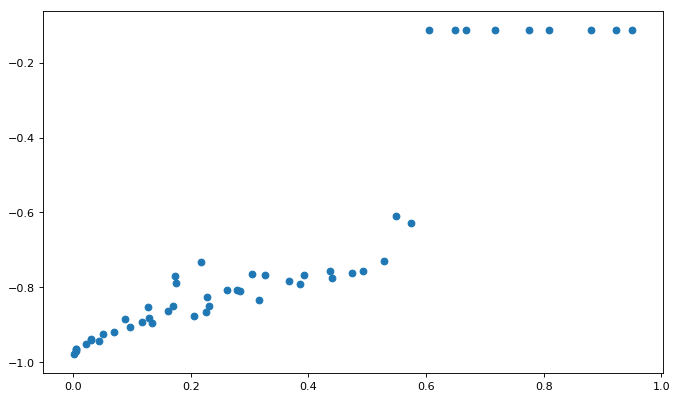

In [43]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

t = trials.trials

y = []
x = []
for tr in t: 
    y.append((tr['result']['loss']))
    x.append(tr['misc']['vals']['l2'])
    

plt.scatter(x, y)
plt.plot()
plt.show()

This is confirming again that the coefficient of L2 regularization is converging to 0. Let's run the best model:

### Running the best model

In [44]:
l2_min = trials.best_trial['misc']['vals']['l2']

model_2 = Sequential()
model_2.add(Dense(512, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(l2_min)))
# model_2.add(Dropout(0.2))
model_2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_min)))
# model_2.add(Dropout(0.2))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.summary()

model_2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test), callbacks=[metrics])
score_2 = model_2.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_382 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_383 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_384 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.6371 - acc: 0.9233 - val_loss: 0.3327 - val_acc: 0.9532
 — val_f1: 0.953578 — val_precision: 0.962416 — val_recall 0.944900
Epoch 2/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.2644 - acc: 0.9611 - val_loss: 0.2208 - val_acc: 0.9657
 — val_f

In [ ]:
As you can see, still the best model performs far less than the network without any L2 regularization